In [1]:
import os
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skopt import BayesSearchCV
from sklearn.tree import DecisionTreeRegressor
from skopt.space import Integer, Categorical, Real
from sklearn.metrics import mean_squared_error,root_mean_squared_error, mean_absolute_error

In [2]:
data = pd.read_csv('data.csv')

X_test = pd.read_csv('X_test.csv')
X_train = pd.read_csv('X_train.csv')
y_test = pd.read_csv('y_test.csv')
y_train = pd.read_csv('y_train.csv')

In [13]:
print("Data shape",data.shape,"\n")
print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

Data shape (1251, 14) 

X_train shape (1000, 5)
y_train shape (1000, 1)
X_test shape (251, 5)
y_test shape (251, 1)


In [61]:
DTmodel = DecisionTreeRegressor(random_state=42)
DTmodel.fit(X_train, y_train)

y_pred_dt = DTmodel.predict(X_test)
y_pred_train_dt = DTmodel.predict(X_train)

In [65]:
mae_dt = mean_absolute_error(y_test, y_pred_dt)
mse_dt = mean_squared_error(y_test, y_pred_dt)
rmse_dt = root_mean_squared_error(y_test, y_pred_dt)

print(f'MAE: {mae_dt:.6f}')
print(f'MSE: {mse_dt:.6f}')
print(f'RMSE: {rmse_dt:.6f}')

MAE: 0.044763
MSE: 0.005411
RMSE: 0.073562


In [66]:
# Ensure the arrays are 1-dimensional
y_test = y_test.values.reshape(-1) if isinstance(y_test, pd.DataFrame) else y_test
y_pred_dt = y_pred_dt.values.reshape(-1) if isinstance(y_pred_dt, pd.DataFrame) else y_pred_dt

# Create a DataFrame to hold actual and predicted values
results_dt = pd.DataFrame({'Actual SOH': y_test, 'Predicted SOH': y_pred_dt})

# Print the actual and predicted SOH values
print(results_dt)

     Actual SOH  Predicted SOH
0        0.1231         0.0655
1        0.3744         0.3798
2        0.1782         0.0972
3        0.4869         0.4857
4        0.3438         0.4408
..          ...            ...
246      0.7323         0.7147
247      0.2741         0.2629
248      0.2306         0.2307
249      0.1856         0.1524
250      0.2840         0.2881

[251 rows x 2 columns]


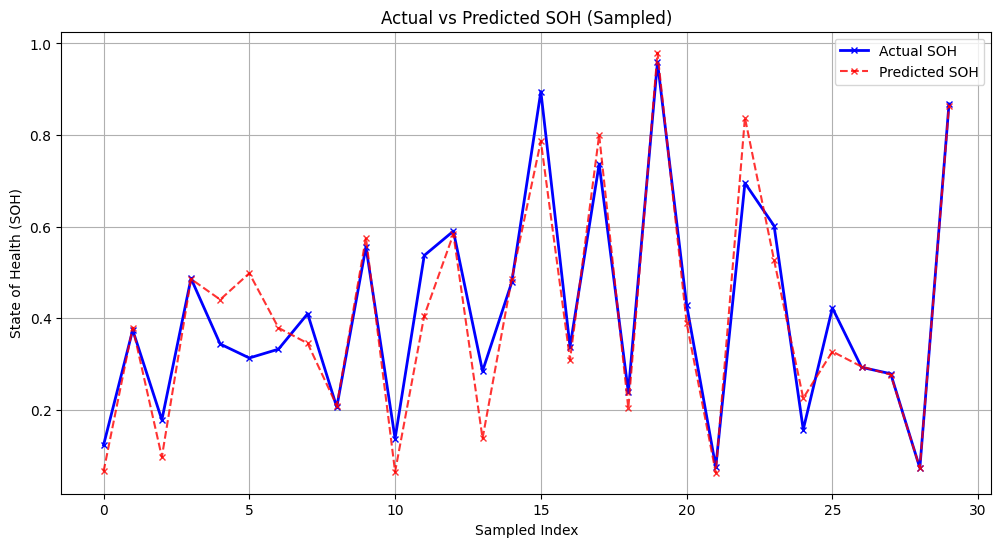

In [67]:
sample_size = 30  # adjust sample size as needed
y_test_sample = y_test[:sample_size]
y_pred_sample = y_pred_dt[:sample_size]
sample_indices = range(sample_size)

# Plot actual and predicted SOH with transparency and markers
plt.figure(figsize=(12, 6))
plt.plot(sample_indices, y_test_sample, label='Actual SOH', color='blue', marker='x', markersize=5, linewidth=2)
plt.plot(sample_indices, y_pred_sample, label='Predicted SOH', color='red', linestyle='--', marker='x', markersize=5, alpha=0.8)
plt.title('Actual vs Predicted SOH (Sampled)')
plt.xlabel('Sampled Index')
plt.ylabel('State of Health (SOH)')
plt.legend()
plt.grid(True)
plt.show()

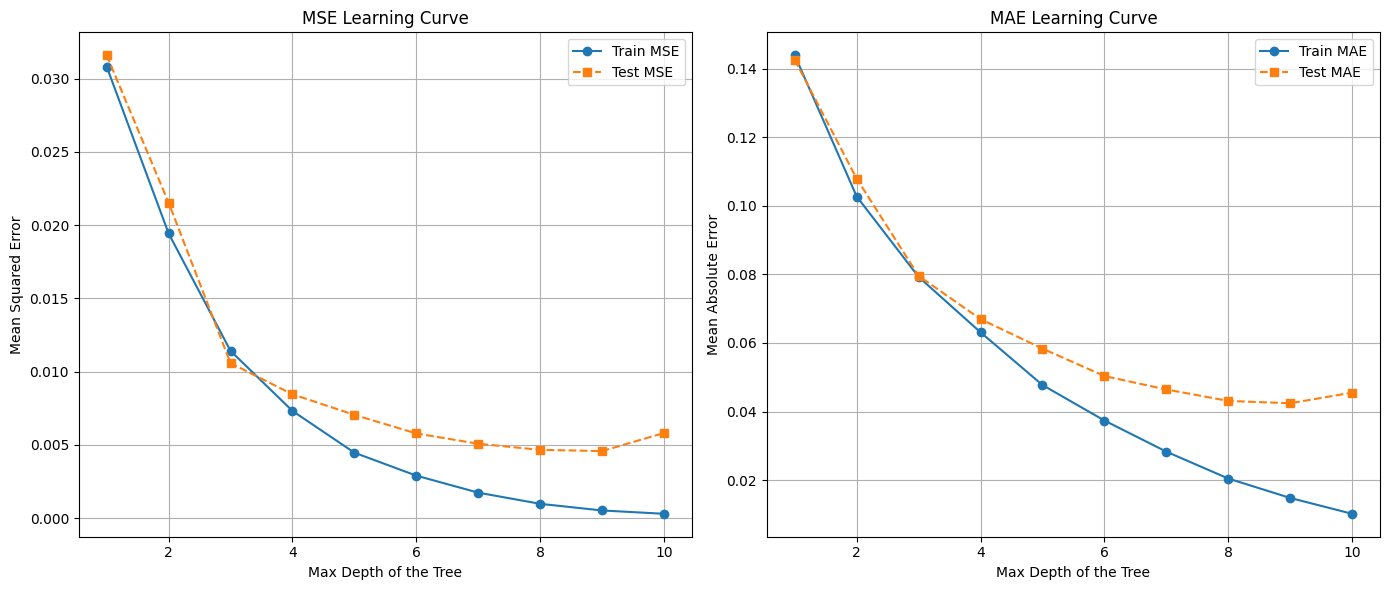

In [69]:
params = DTmodel.get_params()
initial_max_depth = params.get('max_depth', None)  # None if max_depth is not set

# Define a default range if max_depth is None
if initial_max_depth is None:
    initial_max_depth = 10  # Use 20 as a default maximum depth for plotting

# Initialize arrays to store errors
train_mse = []
test_mse = []
train_mae = []
test_mae = []

# Use the initial max_depth as the range
max_depth_range = range(1, initial_max_depth + 1)  # From depth 1 to the initial max depth

for depth in max_depth_range:
    # Update the model's max_depth and re-fit it
    DTmodel.set_params(max_depth=depth)
    DTmodel.fit(X_train, y_train)
    
    # Predict on training and test data
    y_train_pred = DTmodel.predict(X_train)
    y_test_pred = DTmodel.predict(X_test)
    
    # Calculate errors for training and testing
    train_mse.append(mean_squared_error(y_train, y_train_pred))
    test_mse.append(mean_squared_error(y_test, y_test_pred))
    train_mae.append(mean_absolute_error(y_train, y_train_pred))
    test_mae.append(mean_absolute_error(y_test, y_test_pred))

# Plot MSE and MAE learning curves
plt.figure(figsize=(14, 6))

# MSE plot
plt.subplot(1, 2, 1)
plt.plot(max_depth_range, train_mse, label='Train MSE', marker='o')
plt.plot(max_depth_range, test_mse, label='Test MSE', marker='s', linestyle='--')
plt.title('MSE Learning Curve')
plt.xlabel('Max Depth of the Tree')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)

# MAE plot
plt.subplot(1, 2, 2)
plt.plot(max_depth_range, train_mae, label='Train MAE', marker='o')
plt.plot(max_depth_range, test_mae, label='Test MAE', marker='s', linestyle='--')
plt.title('MAE Learning Curve')
plt.xlabel('Max Depth of the Tree')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

**# Hyperparameter tuning**

In [77]:
# Define the hyperparameter search space for Decision Tree
param_space = {
    "max_depth": Integer(1, 30),                     # Maximum depth of the tree
    "min_samples_split": Integer(2, 15),             # Minimum number of samples to split a node
    "min_samples_leaf": Integer(1, 15),              # Minimum number of samples at a leaf node
    "max_features": Categorical(["sqrt", "log2"]),  # Number of features to consider when looking for the best split
    "criterion": Categorical(['squared_error', 'friedman_mse', 'absolute_error', 'poisson'])  # Split criterion
}

# Define the Decision Tree model
decision_tree = DecisionTreeRegressor(random_state=42)

# Use Bayesian Optimization to find the best hyperparameters
bayes_search = BayesSearchCV(
    estimator=decision_tree,
    search_spaces=param_space,
    n_iter=50,  # Number of parameter combinations to try
    cv=3,       # 3-fold cross-validation
    n_jobs=-1,  # Use all available processors
    random_state=42,
    verbose=2
)

# Fit the Bayesian optimizer
bayes_search.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

BayesSearchCV(cv=3, estimator=DecisionTreeRegressor(random_state=42), n_jobs=-1,
              random_state=42,
              search_spaces={'criterion': Categorical(categories=('squared_error', 'friedman_mse', 'absolute_error', 'poisson'), prior=None),
                             'max_depth': Integer(low=1, high=30, prior='uniform', transform='normalize'),
                             'max_features': Categorical(categories=('sqrt', 'log2'), prior=None),
                             'min_samples_leaf': Integer(low=1, high=15, prior='uniform', transform='normalize'),
                             'min_samples_split': Integer(low=2, high=15, prior='uniform', transform='normalize')},
              verbose=2)

In [78]:
# Get the best hyperparameters
best_params = bayes_search.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: OrderedDict([('criterion', 'poisson'), ('max_depth', 30), ('max_features', 'sqrt'), ('min_samples_leaf', 4), ('min_samples_split', 8)])


In [79]:
# Train the final model using the best hyperparameters
best_dt_model = DecisionTreeRegressor(**best_params, random_state=42)
best_dt_model.fit(X_train, y_train)

# Make predictions
y_pred_dt = best_dt_model.predict(X_test)

In [80]:
mae_dt = mean_absolute_error(y_test, y_pred_dt)
mse_dt = mean_squared_error(y_test, y_pred_dt)
rmse_dt = root_mean_squared_error(y_test, y_pred_dt)

print(f'MAE: {mae_dt:.6f}')
print(f'MSE: {mse_dt:.6f}')
print(f'RMSE: {rmse_dt:.6f}')

MAE: 0.041661
MSE: 0.004468
RMSE: 0.066845


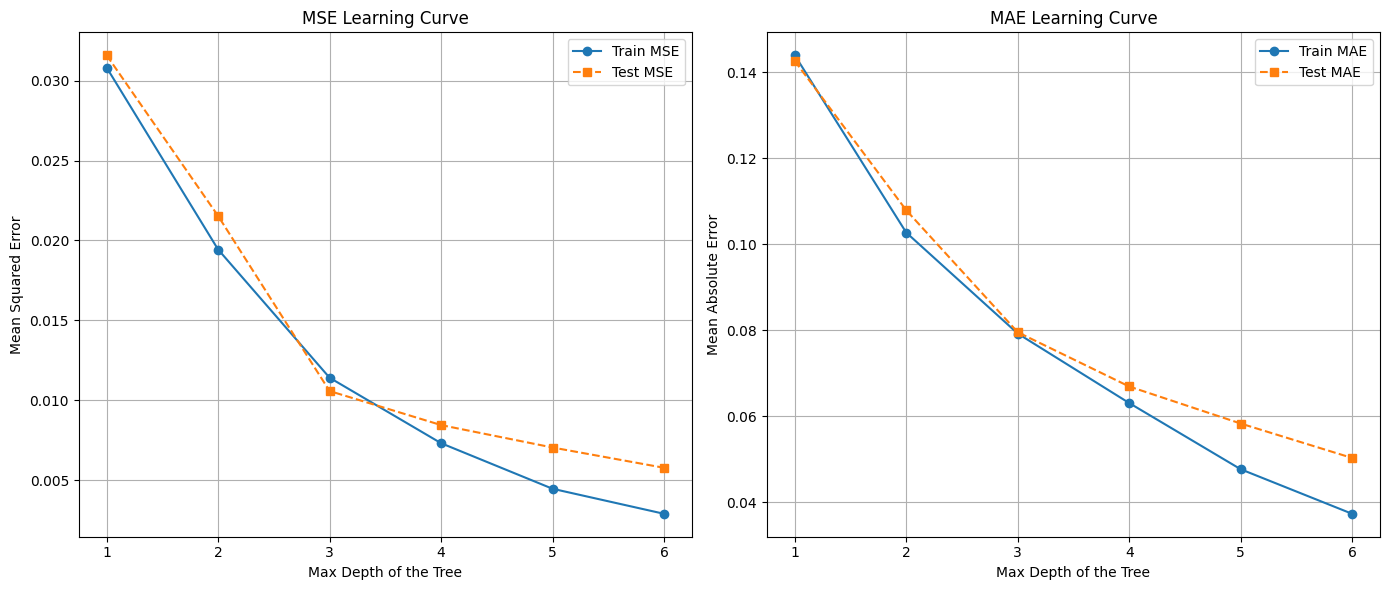

In [91]:
def plot_decision_tree_depth_learning_curve(X_train, y_train, X_test, y_test, max_depth_range):
    train_mse, test_mse = [], []
    train_mae, test_mae = [], []
    
    for max_depth in max_depth_range:
        # Initialize and train a Decision Tree model with the current max_depth
        dt_model = DecisionTreeRegressor(max_depth=max_depth)
        dt_model.fit(X_train, y_train)

        # Predictions
        y_train_pred = dt_model.predict(X_train)
        y_test_pred = dt_model.predict(X_test)

        # Calculate metrics
        train_mse.append(mean_squared_error(y_train, y_train_pred))
        test_mse.append(mean_squared_error(y_test, y_test_pred))
        train_mae.append(mean_absolute_error(y_train, y_train_pred))
        test_mae.append(mean_absolute_error(y_test, y_test_pred))

    # Plot MSE and MAE Learning Curves
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    # Plot MSE
    axs[0].plot(max_depth_range, train_mse, label="Train MSE", marker='o', linestyle='-')
    axs[0].plot(max_depth_range, test_mse, label="Test MSE", marker='s', linestyle='--')
    axs[0].set_title("MSE Learning Curve")
    axs[0].set_xlabel("Max Depth of the Tree")
    axs[0].set_ylabel("Mean Squared Error")
    axs[0].legend()
    axs[0].grid(True)

    # Plot MAE
    axs[1].plot(max_depth_range, train_mae, label="Train MAE", marker='o', linestyle='-')
    axs[1].plot(max_depth_range, test_mae, label="Test MAE", marker='s', linestyle='--')
    axs[1].set_title("MAE Learning Curve")
    axs[1].set_xlabel("Max Depth of the Tree")
    axs[1].set_ylabel("Mean Absolute Error")
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

# Example Usage:
# Define the range of max depths to test (for example, from 1 to 20)
max_depth_range = np.arange(1, 7)

# Call the function with your data
plot_decision_tree_depth_learning_curve(X_train, y_train, X_test, y_test, max_depth_range)

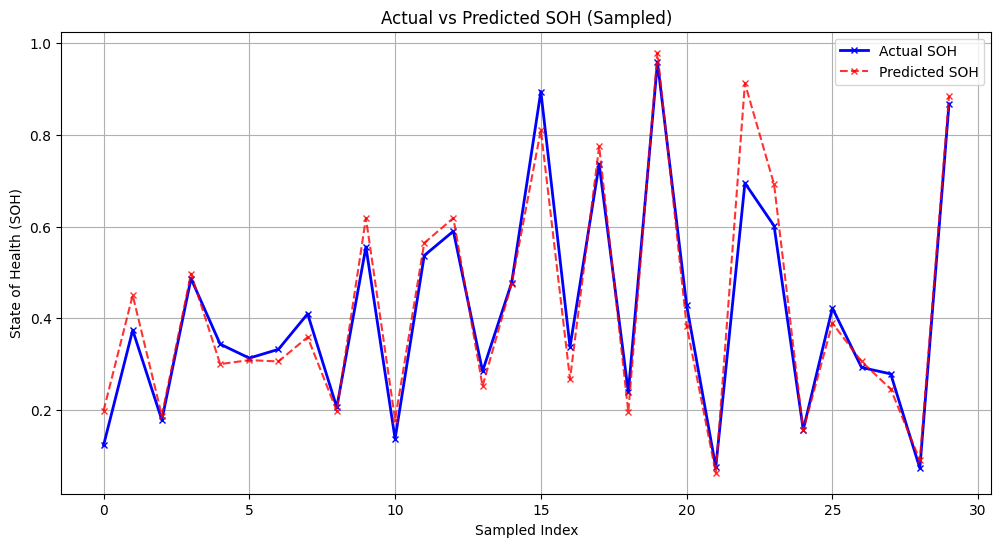

In [40]:
# Sample data for clearer visualization if the dataset is large
sample_size = 30  # adjust sample size as needed
y_test_sample = y_test[:sample_size]
y_pred_sample = y_pred_dt[:sample_size]
sample_indices = range(sample_size)

# Plot actual and predicted SOH with transparency and markers
plt.figure(figsize=(12, 6))
plt.plot(sample_indices, y_test_sample, label='Actual SOH', color='blue', marker='x', markersize=5, linewidth=2)
plt.plot(sample_indices, y_pred_sample, label='Predicted SOH', color='red', linestyle='--', marker='x', markersize=5, alpha=0.8)
plt.title('Actual vs Predicted SOH (Sampled)')
plt.xlabel('Sampled Index')
plt.ylabel('State of Health (SOH)')
plt.legend()
plt.grid(True)
plt.show()

In [41]:
# Ensure the arrays are 1-dimensional
y_test = y_test.values.reshape(-1) if isinstance(y_test, pd.DataFrame) else y_test
y_pred_dt = y_pred_dt.values.reshape(-1) if isinstance(y_pred_dt, pd.DataFrame) else y_pred_dt

# Create a DataFrame to hold actual and predicted values
results_dt = pd.DataFrame({'Actual SOH': y_test, 'Predicted SOH': y_pred_dt})

# Print the actual and predicted SOH values
print(results_dt)

     Actual SOH  Predicted SOH
0        0.1231       0.198540
1        0.3744       0.450567
2        0.1782       0.187800
3        0.4869       0.497675
4        0.3438       0.300275
..          ...            ...
246      0.7323       0.810800
247      0.2741       0.276600
248      0.2306       0.217875
249      0.1856       0.168329
250      0.2840       0.204860

[251 rows x 2 columns]


**# Hyperparameter Tuning, cv = 5**

In [42]:
# Define the hyperparameter search space for Decision Tree
param_space = {
    "max_depth": Integer(1, 30),                     # Maximum depth of the tree
    "min_samples_split": Integer(2, 15),             # Minimum number of samples to split a node
    "min_samples_leaf": Integer(1, 15),              # Minimum number of samples at a leaf node
    "max_features": Categorical(["sqrt", "log2"]),  # Number of features to consider when looking for the best split
    "criterion": Categorical(['squared_error', 'friedman_mse', 'absolute_error', 'poisson'])  # Split criterion
}

# Define the Decision Tree model
decision_tree = DecisionTreeRegressor(random_state=42)

# Use Bayesian Optimization to find the best hyperparameters
bayes_search = BayesSearchCV(
    estimator=decision_tree,
    search_spaces=param_space,
    n_iter=50,  # Number of parameter combinations to try
    cv=5,       # 3-fold cross-validation
    n_jobs=-1,  # Use all available processors
    random_state=42,
    verbose=2
)

# Fit the Bayesian optimizer
bayes_search.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

BayesSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42), n_jobs=-1,
              random_state=42,
              search_spaces={'criterion': Categorical(categories=('squared_error', 'friedman_mse', 'absolute_error', 'poisson'), prior=None),
                             'max_depth': Integer(low=1, high=30, prior='uniform', transform='normalize'),
                             'max_features': Categorical(categories=('sqrt', 'log2'), prior=None),
                             'min_samples_leaf': Integer(low=1, high=15, prior='uniform', transform='normalize'),
                             'min_samples_split': Integer(low=2, high=15, prior='uniform', transform='normalize')},
              verbose=2)

In [43]:
# Get the best hyperparameters
best_params = bayes_search.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: OrderedDict([('criterion', 'poisson'), ('max_depth', 21), ('max_features', 'log2'), ('min_samples_leaf', 7), ('min_samples_split', 7)])


In [44]:
# Train the final model using the best hyperparameters
best_dt_model = DecisionTreeRegressor(**best_params, random_state=42)
best_dt_model.fit(X_train, y_train)

# Make predictions
y_pred_dt = best_dt_model.predict(X_test)

In [45]:
mae_dt = mean_absolute_error(y_test, y_pred_dt)
mse_dt = mean_squared_error(y_test, y_pred_dt)
rmse_dt = root_mean_squared_error(y_test, y_pred_dt)

print(f'MAE: {mae_dt:.6f}')
print(f'MSE: {mse_dt:.6f}')
print(f'RMSE: {rmse_dt:.6f}')

MAE: 0.052991
MSE: 0.006695
RMSE: 0.081820


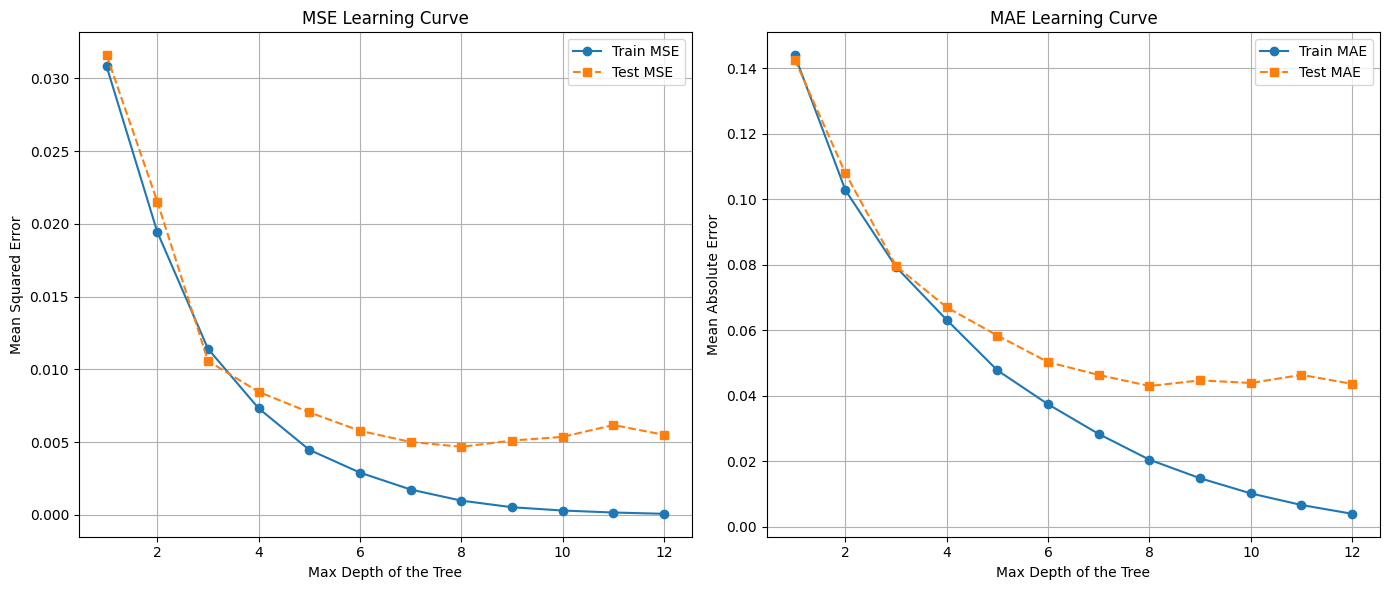

In [46]:
def plot_decision_tree_depth_learning_curve(X_train, y_train, X_test, y_test, max_depth_range):
    train_mse, test_mse = [], []
    train_mae, test_mae = [], []
    
    for max_depth in max_depth_range:
        # Initialize and train a Decision Tree model with the current max_depth
        dt_model = DecisionTreeRegressor(max_depth=max_depth)
        dt_model.fit(X_train, y_train)

        # Predictions
        y_train_pred = dt_model.predict(X_train)
        y_test_pred = dt_model.predict(X_test)

        # Calculate metrics
        train_mse.append(mean_squared_error(y_train, y_train_pred))
        test_mse.append(mean_squared_error(y_test, y_test_pred))
        train_mae.append(mean_absolute_error(y_train, y_train_pred))
        test_mae.append(mean_absolute_error(y_test, y_test_pred))

    # Plot MSE and MAE Learning Curves
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    # Plot MSE
    axs[0].plot(max_depth_range, train_mse, label="Train MSE", marker='o', linestyle='-')
    axs[0].plot(max_depth_range, test_mse, label="Test MSE", marker='s', linestyle='--')
    axs[0].set_title("MSE Learning Curve")
    axs[0].set_xlabel("Max Depth of the Tree")
    axs[0].set_ylabel("Mean Squared Error")
    axs[0].legend()
    axs[0].grid(True)

    # Plot MAE
    axs[1].plot(max_depth_range, train_mae, label="Train MAE", marker='o', linestyle='-')
    axs[1].plot(max_depth_range, test_mae, label="Test MAE", marker='s', linestyle='--')
    axs[1].set_title("MAE Learning Curve")
    axs[1].set_xlabel("Max Depth of the Tree")
    axs[1].set_ylabel("Mean Absolute Error")
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

# Example Usage:
# Define the range of max depths to test (for example, from 1 to 20)
max_depth_range = np.arange(1, 13)

# Call the function with your data
plot_decision_tree_depth_learning_curve(X_train, y_train, X_test, y_test, max_depth_range)

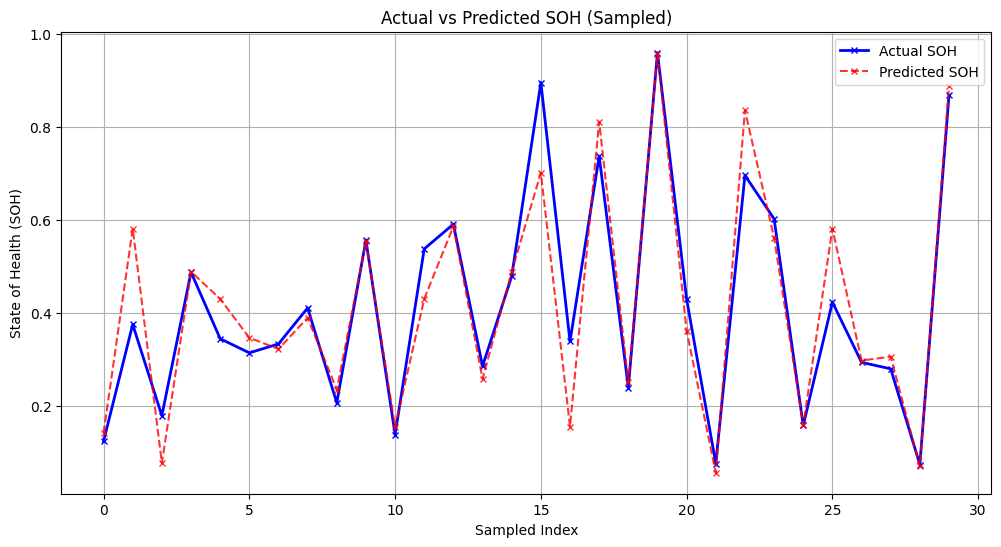

In [47]:
# Sample data for clearer visualization if the dataset is large
sample_size = 30  # adjust sample size as needed
y_test_sample = y_test[:sample_size]
y_pred_sample = y_pred_dt[:sample_size]
sample_indices = range(sample_size)

# Plot actual and predicted SOH with transparency and markers
plt.figure(figsize=(12, 6))
plt.plot(sample_indices, y_test_sample, label='Actual SOH', color='blue', marker='x', markersize=5, linewidth=2)
plt.plot(sample_indices, y_pred_sample, label='Predicted SOH', color='red', linestyle='--', marker='x', markersize=5, alpha=0.8)
plt.title('Actual vs Predicted SOH (Sampled)')
plt.xlabel('Sampled Index')
plt.ylabel('State of Health (SOH)')
plt.legend()
plt.grid(True)
plt.show()

In [49]:
# Ensure the arrays are 1-dimensional
y_test = y_test.values.reshape(-1) if isinstance(y_test, pd.DataFrame) else y_test
y_pred_dt = y_pred_dt.values.reshape(-1) if isinstance(y_pred_dt, pd.DataFrame) else y_pred_dt

# Create a DataFrame to hold actual and predicted values
results_dt = pd.DataFrame({'Actual SOH': y_test, 'Predicted SOH': y_pred_dt.round(4)})

# Print the actual and predicted SOH values
print(results_dt)

     Actual SOH  Predicted SOH
0        0.1231         0.1406
1        0.3744         0.5807
2        0.1782         0.0762
3        0.4869         0.4879
4        0.3438         0.4295
..          ...            ...
246      0.7323         0.7008
247      0.2741         0.2302
248      0.2306         0.2302
249      0.1856         0.2012
250      0.2840         0.3051

[251 rows x 2 columns]
